### Part 2:  Pose Graph Optimization for 2D SLAM

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [ ]:
!pip3 install jax jaxlib

In [1]:
import math
import copy
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jacfwd

### Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


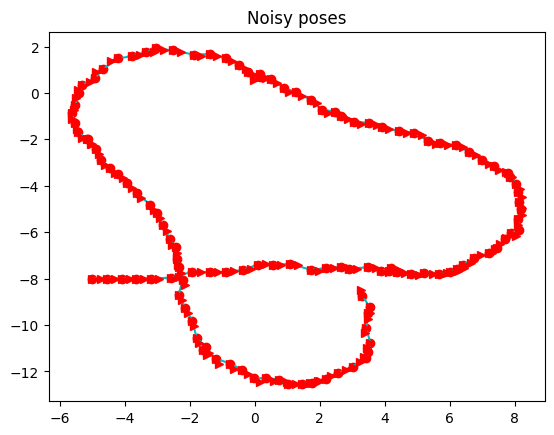

In [2]:
"""
To plot the initial noisy poses given as input readings
"""
def draw_plot(X, Y, THETA):
    plt.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')
    num_points = X.shape[0]
    for i in range(num_points):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
    plt.title("Noisy poses")
    plt.show()

def extract_vertices_edges(filename):
    vertices = []
    edges = []
    with open(filename, 'r') as file:
        for line in file:
            line_data = line.split()
            data_type = line_data[0]
            data = line_data[1:]
            if data_type=='VERTEX_SE2':
                vertices.append(jnp.array(jnp.float32(data)))
            elif data_type=='EDGE_SE2':
                edges.append(jnp.array(jnp.float32(data)))

    return jnp.array(vertices), jnp.array(edges)

vertices, edges = extract_vertices_edges("../data/edges.txt")
gt_vertices, gt_edges = extract_vertices_edges("../data/gt.txt")

"""
Extract the values of dx, dy and dtheta
"""

dx = edges[:, 2]
dy = edges[:, 3]
dtheta = edges[:, 4]

final_poses = [[vertices[0][1], vertices[0][2], vertices[0][3]]]

"""
119 edges (i,j) , others are loop closure edges
"""

for i in range(119):
    next_vertex = copy.deepcopy(final_poses[-1])
    delta = [dx[i]*math.cos(final_poses[-1][2])-dy[i]*math.sin(final_poses[-1][2]), 
             dx[i]*math.sin(final_poses[-1][2])+dy[i]*math.cos(final_poses[-1][2]), 
             dtheta[i]]
    newx = next_vertex[0] + delta[0]
    newy = next_vertex[1] + delta[1]
    newtheta = next_vertex[2] + delta[2]
    final_poses.append([newx, newy, newtheta])

final_poses = jnp.asarray(final_poses)

with open("./edges-poses.g2o", 'w') as file:
    idx = 0
    for vertex in final_poses:
        file.write("VERTEX_SE2 ")
        file.write(str(idx))
        file.write(" ")
        for value in vertex:
            file.write(str(value))
            file.write(' ')
        file.write('\n')
        idx += 1

final_poses_plt = copy.deepcopy(final_poses)
draw_plot(final_poses[:, 0], final_poses[:,1], final_poses[:,2])

### Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this assignment. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [3]:
def f_x(poses, edges, vertex):
    poses = jnp.asarray(poses)

    temp_vert = copy.deepcopy(vertex)
    anchor = temp_vert.flatten()[1:]
    residuals = list(poses[0] - anchor)

    num_edges = edges.shape[0]

    for i in range(num_edges):
        ind1      = int(edges[i][0])
        ind2      = int(edges[i][1])
        del_x     = edges[i][2]
        del_y     = edges[i][3]
        del_theta = edges[i][4]

        x     = poses[ind1][0]
        y     = poses[ind1][1]
        theta = poses[ind1][2]

        x_new     = x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta)
        y_new     = y + del_y * jnp.cos(theta) + del_x * jnp.sin(theta)
        theta_new = theta + del_theta

        estimated_next_pose = jnp.array([x_new, y_new, theta_new])
        diff                = list(estimated_next_pose - poses[ind2])
        residuals          += diff

    return jnp.asarray(residuals)

def Jacobian(poses, edges):
    poses = jnp.asarray(poses)

    num_anchors  = 1
    num_edges    = edges.shape[0]
    num_vertices = poses.shape[0]

    J = jnp.zeros(((num_anchors + num_edges) * 3, num_vertices * 3))

    for i in range(num_anchors):
        J = J.at[[3 * i, 3 * i + 1, 3 * i + 2], [3 * i, 3 * i + 1, 3 * i + 2]].set(1)

    for i in range(num_edges):
        row = i * 3 + 3

        ind1      = int(edges[i][0])
        ind2      = int(edges[i][1])
        del_x     = edges[i][2]
        del_y     = edges[i][3]
        theta     = poses[ind1][4]

        J = J.at[[row, row + 1, row + 2], [ind1 * 3, ind1 * 3 + 1, ind1 * 3 + 2]].set(1)
        J = J.at[row, ind1 * 3 + 2].set(-del_x * jnp.sin(theta) - del_y * jnp.cos(theta))
        J = J.at[row + 1, ind1 * 3 + 2].set(-del_y * jnp.sin(theta) + del_x * jnp.cos(theta))

        J = J.at[[row, row + 1, row + 2], [ind2 * 3, ind2 * 3 + 1, ind2 * 3 + 2]].set(-1)

    return J

def get_Info_Matrix(poses, edges, odom_weight=100, loop_closure_weight=1000, anchor_weight=2000):
    num_anchors       = 1
    num_odoms         = poses.shape[0]
    num_loop_closures = edges.shape[0] - num_odoms

    info_m = jnp.zeros((num_anchors + num_odoms + num_loop_closures) * 3, dtype=jnp.int32)

    info_m = info_m.at[:3 * num_anchors].set(jnp.full(3, anchor_weight))
    info_m = info_m.at[3 * num_anchors:3 * (num_odoms)].set(jnp.full(3 * (num_odoms - 1), odom_weight))
    info_m = info_m.at[3 * (num_odoms):].set(jnp.full(3 * (num_loop_closures + 1), loop_closure_weight))

    return jnp.diag(info_m)

info_matrix     = get_Info_Matrix(final_poses, edges)
residual_matrix = f_x(final_poses, edges, vertices)
J               = Jacobian(final_poses, edges)

In [4]:
def draw(X, Y, THETA, X_new, Y_new, THETA_new):
    plt.plot(X, Y, 'ro', label="Noisy Poses")
    plt.plot(X, Y, 'c-')
    num_points = X.shape[0]
    for i in range(num_points):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
    
    plt.plot(gt_vertices[:, 1], gt_vertices[:, 2], 'bo', label="Ground-Truth Poses")
    plt.plot(gt_vertices[:, 1], gt_vertices[:, 2], 'c-')

    for i in range(len(gt_vertices)):
        x2 = 0.25*math.cos(gt_vertices[i][3]) + gt_vertices[i][1]
        y2 = 0.25*math.sin(gt_vertices[i][3]) + gt_vertices[i][2]
        plt.plot([gt_vertices[i][1], x2], [gt_vertices[i][2], y2], 'b->')

    plt.plot(X_new, Y_new, 'go', label="Updated Poses")
    plt.plot(X_new, Y_new, 'c-')
    num_points = X_new.shape[0]
    for i in range(num_points):
        x2 = 0.25*math.cos(THETA_new[i]) + X_new[i]
        y2 = 0.25*math.sin(THETA_new[i]) + Y_new[i]
        plt.plot([X_new[i], x2], [Y_new[i], y2], 'g->')
    
    plt.legend()
    plt.show()

Frobenius norm between Our Jacobian and JAX Jacobian is 0.0


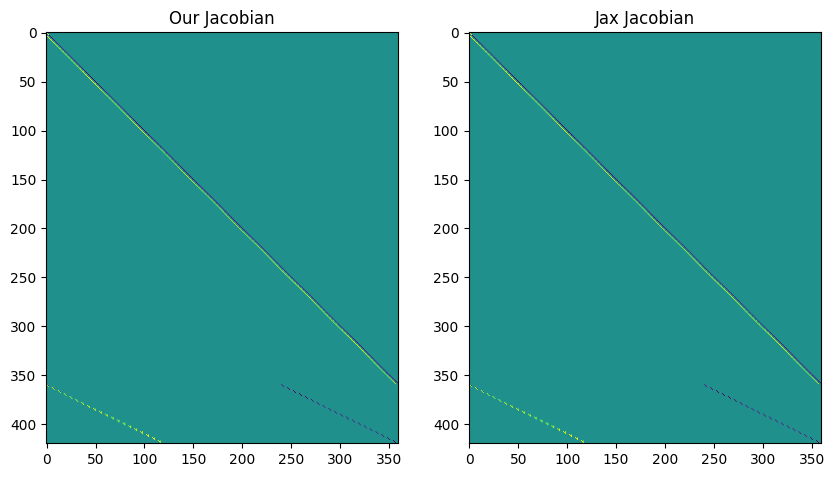

In [5]:
f = lambda poses, edges, vertex: f_x(poses, edges, vertex)
J_jax = jacfwd(f)

calc_J = J_jax(final_poses, edges, vertices)
calc_J = calc_J.reshape((edges.shape[0] + len(vertices)) * 3, -1, 1)[:, :, 0]

print(f"Frobenius norm between Our Jacobian and JAX Jacobian is {jnp.linalg.norm(J - calc_J, 'fro')}")

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(J)
axs[1].imshow(calc_J)

axs[0].set_title('Our Jacobian')
axs[1].set_title('Jax Jacobian')

plt.show()

In [6]:
def tuning_LM(poses, edges, iterations=50, tolerance=1e-5, lm_lambda=0.1, odom_weight=100, loop_closure_weight=1000, anchor_weight=2000):
    poses = jnp.asarray(poses)

    info_m = get_Info_Matrix(poses, edges, odom_weight, loop_closure_weight, anchor_weight)

    converged = False

    print(f"Params: Odometry weight = {odom_weight}, Loop-closure weight = {loop_closure_weight}, Anchor weight = {anchor_weight} and Lambda = {lm_lambda}")
    
    for i in range(iterations):
        f_x_curr = f_x(poses, edges, vertices)

        J = Jacobian(poses, edges)

        prev_err = 0.5 * f_x_curr.T @ info_m.T @ f_x_curr

        H = J.T @ info_m @ J

        I = jnp.eye(H.shape[0])

        H = H + lm_lambda * I
        B = -J.T @ info_m @ f_x_curr
        delta = jnp.linalg.solve(H, B)

        delta = delta.reshape((120, 3))
        new_poses = poses + delta

        f_x_new = f_x(new_poses, edges, vertices)
        curr_err = 0.5 * f_x_new.T @ info_m.T @ f_x_new 

        if jnp.linalg.norm(new_poses - poses) < tolerance:
            break

        if jnp.round(curr_err, 3) == jnp.round(prev_err, 3):
            print(f"Converged by epoch {i + 1} with error of {curr_err}")
            converged = True
            break

        poses = new_poses

        if (curr_err > prev_err):
            lm_lambda = lm_lambda * 5
        else:
            lm_lambda = lm_lambda / 5

    if not converged:
        print(f"Error of {curr_err} after {iterations}")

    print()

params = [
    [0.1, 500, 700, 1000],
    [0.1, 100, 1000, 2000],
    [0.01, 50, 500, 1000],
    [0.1, 10, 100, 200],
    [0.01, 10, 100, 200],
    [0.1, 1, 10, 20],
    [0.01, 1, 10, 20],
]

for i in params:
    tuning_LM(final_poses, edges, lm_lambda=i[0], odom_weight=i[1], loop_closure_weight=i[2], anchor_weight=i[3])

Params: Odometry weight = 500, Loop-closure weight = 700, Anchor weight = 1000 and Lambda = 0.1
Converged by epoch 19 with error of 444.5769348144531

Params: Odometry weight = 100, Loop-closure weight = 1000, Anchor weight = 2000 and Lambda = 0.1
Converged by epoch 20 with error of 95.22270202636719

Params: Odometry weight = 50, Loop-closure weight = 500, Anchor weight = 1000 and Lambda = 0.01
Converged by epoch 18 with error of 47.611541748046875

Params: Odometry weight = 10, Loop-closure weight = 100, Anchor weight = 200 and Lambda = 0.1
Converged by epoch 30 with error of 9.522562980651855

Params: Odometry weight = 10, Loop-closure weight = 100, Anchor weight = 200 and Lambda = 0.01
Converged by epoch 17 with error of 9.52252197265625

Params: Odometry weight = 1, Loop-closure weight = 10, Anchor weight = 20 and Lambda = 0.1
Converged by epoch 28 with error of 0.952671229839325

Params: Odometry weight = 1, Loop-closure weight = 10, Anchor weight = 20 and Lambda = 0.01
Converged

In [6]:
def run_LM(poses, edges, lm_lambda=0.1, iterations=50, tolerance=1e-8):
    poses = jnp.asarray(poses)

    info_m = get_Info_Matrix(poses, edges, odom_weight=1, loop_closure_weight=10, anchor_weight=20)

    for i in range(iterations):
        f_x_curr = f_x(poses, edges, vertices)

        J = Jacobian(poses, edges)

        prev_err = 0.5 * f_x_curr.T @ info_m.T @ f_x_curr

        H = J.T @ info_m @ J

        I = jnp.eye(H.shape[0])

        H = H + lm_lambda * I
        B = -J.T @ info_m @ f_x_curr
        delta = jnp.linalg.solve(H, B)

        delta = delta.reshape((120, 3))
        new_poses = poses + delta

        f_x_new = f_x(new_poses, edges, vertices)
        curr_err = 0.5 * f_x_new.T @ info_m.T @ f_x_new 
        print("Error after epoch " + str(i+1) + ' is: ' + str(curr_err))

        if jnp.linalg.norm(new_poses - poses) < tolerance:
            break

        poses = new_poses

        if(i%5==0):
            draw(final_poses_plt[:, 0], final_poses_plt[:,1], final_poses_plt[:,2], poses[:, 0], poses[:,1], poses[:,2])

        if (curr_err > prev_err):
            lm_lambda = lm_lambda * 5
        else:
            lm_lambda = lm_lambda / 5

    return poses

Error after epoch 1 is: 1616.2461


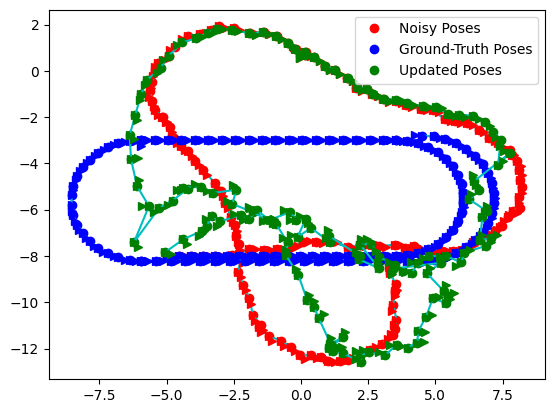

Error after epoch 2 is: 20.68638
Error after epoch 3 is: 8.663968
Error after epoch 4 is: 10.294516
Error after epoch 5 is: 3.7212362
Error after epoch 6 is: 4.1643305


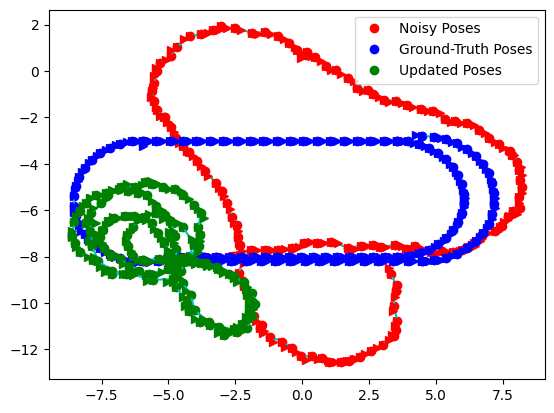

Error after epoch 7 is: 2.8210905
Error after epoch 8 is: 2.8170922
Error after epoch 9 is: 4.849594
Error after epoch 10 is: 2.101663
Error after epoch 11 is: 3.8678463


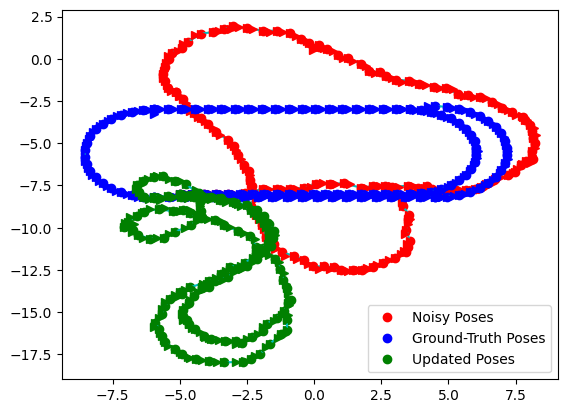

Error after epoch 12 is: 1.7444413
Error after epoch 13 is: 2.9024825
Error after epoch 14 is: 1.4756608
Error after epoch 15 is: 1.9530693
Error after epoch 16 is: 1.2884114


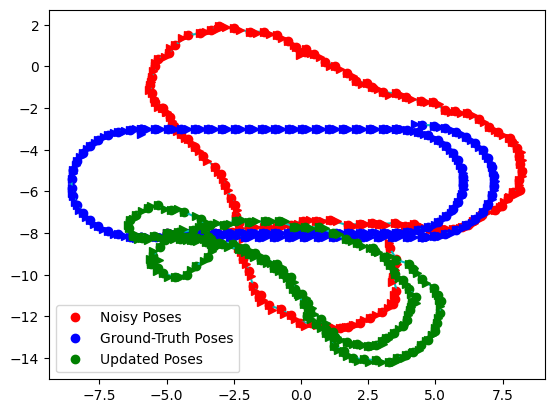

Error after epoch 17 is: 1.4258224
Error after epoch 18 is: 1.1618515
Error after epoch 19 is: 1.1818258
Error after epoch 20 is: 1.0788536
Error after epoch 21 is: 1.0676644


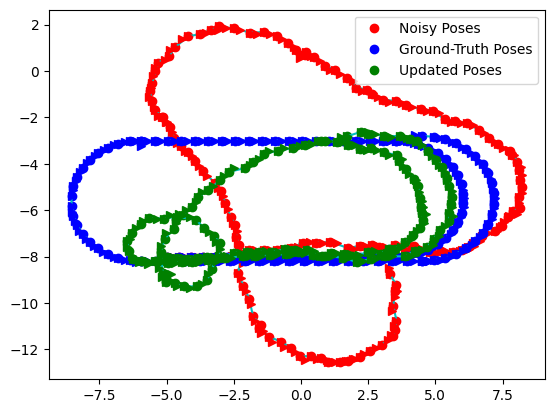

Error after epoch 22 is: 1.0856872
Error after epoch 23 is: 0.9816891
Error after epoch 24 is: 0.97729826
Error after epoch 25 is: 0.9606417
Error after epoch 26 is: 0.95517844


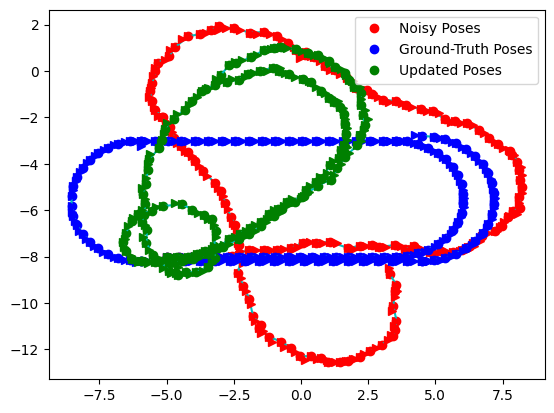

Error after epoch 27 is: 0.9533321
Error after epoch 28 is: 0.95267123
Error after epoch 29 is: 0.9524111
Error after epoch 30 is: 0.952304
Error after epoch 31 is: 0.9522589


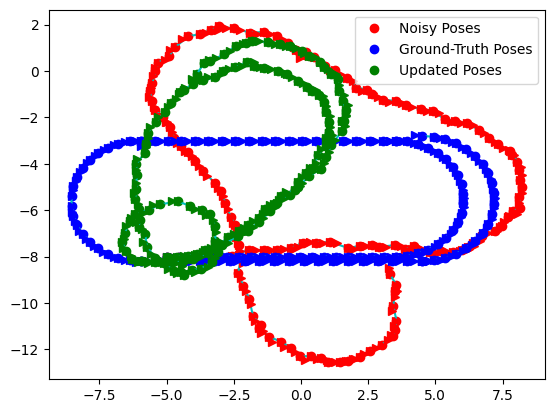

Error after epoch 32 is: 0.95223945
Error after epoch 33 is: 0.95223093
Error after epoch 34 is: 0.9522279
Error after epoch 35 is: 0.9522266
Error after epoch 36 is: 0.9522254


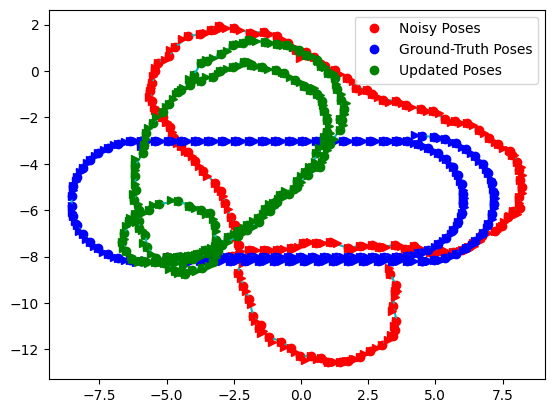

Error after epoch 37 is: 0.9522252
Error after epoch 38 is: 0.9522251
Error after epoch 39 is: 0.9522254
Error after epoch 40 is: 0.9522254
Error after epoch 41 is: 0.95222485


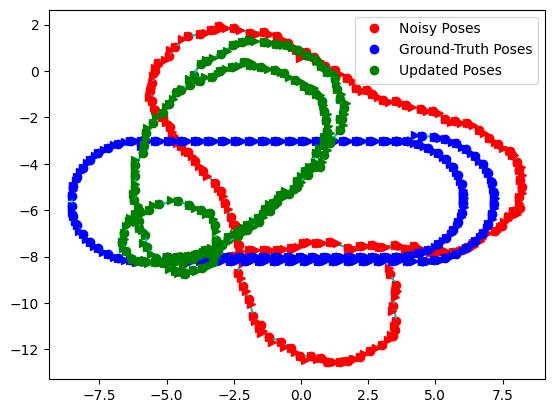

Error after epoch 42 is: 0.95222527
Error after epoch 43 is: 0.9522246
Error after epoch 44 is: 0.95222604
Error after epoch 45 is: 0.9522248
Error after epoch 46 is: 0.9522255


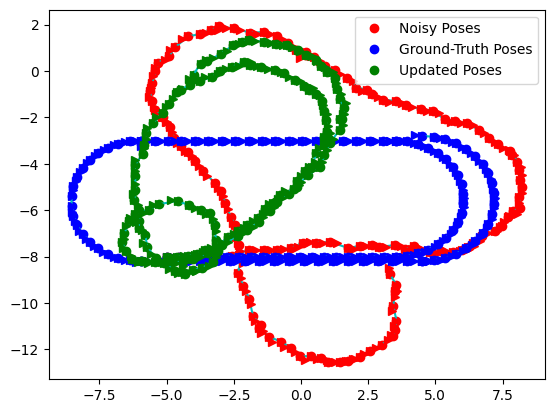

Error after epoch 47 is: 0.9522246
Error after epoch 48 is: 0.95222485
Error after epoch 49 is: 0.9522247
Error after epoch 50 is: 0.95222473


In [7]:
updated_poses = run_LM(final_poses, edges)

Final Trajectory after 50 epochs is:



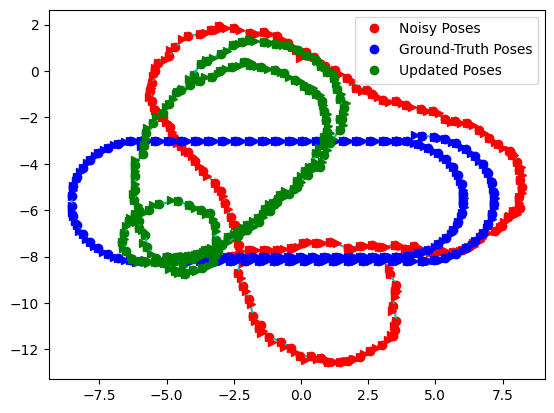

In [8]:
print("Final Trajectory after 50 epochs is:")
print()
draw(final_poses_plt[:, 0], final_poses_plt[:,1], final_poses_plt[:,2], updated_poses[:, 0], updated_poses[:,1], updated_poses[:,2])

### Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

1) The residual function f_x uses the odometry and loop closure constraints along with the information about edge and vertices to calculate the new estimated poses. The size of the residual is `((num_vertices + num_loop_closures + num_anchors) * 3, 1)`, where the `3` is to handle the `3` variables `x, y, theta` corresponding to each of the vertices. The residual is created by appending the differences between the calculated poses and the observed poses for the second point in each edge. Hence, there would be `num_vertices + num_loop_closures + num_anchors` groups of `[del_x, del_y, del_theta]` all flattened into a single array

2) There are a total of `num_vertices * 3` odometry constraints, `num_loop_closures * 3` loop constraints and `num_anchors * 3` anchor constraints from the data collected. We also have `num_vertices * 3` variables. So, we arrive at the Jacobian size of `((num_vertices + num_loop_closures + num_anchors) * 3, num_vertices * 3)`. Now, since the residual follows the order `[del_x1, del_y1, del_theta1, del_x2, del_y2, del_theta2, ...]`, we take the partial derivative of the residual function in the order `x1, y1, theta1, x2, y2, theta2, ...`

3) We can easily infer the convergence of the LM optimisation from the constant reduction in the error with every epoch. But, we can notice from the plots that the trajectory has not fully aligned showing that this is a local minima and not the global minima. The phenomemnon of getting stuck in such a local minima is clearly shown in the hyperparameter tuning loop cell. With higher values of weights, we get stuck in a worse local minima and as we go towards a lower weight initialisation for the information matrix, we move towards a better local minima. As we can also see from the hyperparameter tuning, learning rate initialisation impacts how quickly we converge to the minima, but its impact is not that much when there is good initialisation of weights.

4) As observed from the above plots, we can see that at some point in the optimisation, the process recognised the trajectory to have two loops around the elliptical path and after some iterations, it almost correctly aligns the trajectory on the right half but is unable to align the two loops corresponding to the left half to the actual ground truth. This causes the entire trajectory to deviate from the ground truth and getting stuck in the trajectory estimate that is a local minima which we finally observe

### Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [9]:
num = -1
with open('./output.g2o', 'w') as filehandle:
    for pose in updated_poses:
        filehandle.writelines("VERTEX_SE2 " )
        num = num + 1
        filehandle.writelines("%s " % num)
        for i in pose:
            filehandle.writelines("%s " % i)
        filehandle.writelines("\n")